# Project: Stock Price Prediction

In [378]:
#import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Overall Goal

Predict stock price (closing) on day X+1 as precisely as possible.

### Data Import And Cleaning

In [365]:
#get data

path_to_df = "..\Data\SPX.csv"
df = pd.read_csv(path_to_df)

df = df[::-1].reset_index(drop=True) #reverse order

df.head()

,Date,Close/Last,Open,High,Low
0,02/24/2014,1847.61,1836.78,1858.71,1836.78
1,02/25/2014,1845.12,1847.66,1852.91,1840.19
2,02/26/2014,1845.16,1845.79,1852.65,1840.66
3,02/27/2014,1854.29,1844.90,1854.53,1841.13
4,02/28/2014,1859.45,1855.12,1867.92,1847.67


In [647]:
path_to_apple_data = "..\Data\AAPL.csv"
apple = pd.read_csv(path_to_apple_data)

apple.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.470742,493729600
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.481930,601904800
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.378824,552160000
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.367033,477131200
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.409361,447610800


In [366]:
def plot_chart(df, col, is_df=True): # Plotting the col against dates
    # Create a larger plot
    fig, ax = plt.subplots(figsize=(12, 6))
    num_args = len(col)

    for ind in range(num_args):
        if is_df:
            ax.plot(df['Date'], df[col[ind]])
        else:
            ax.plot(df['Date'], col[ind])

    ax.set_title('Plot of price over time')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')

    # Automatically set the x-axis date labels based on available space
    ax.xaxis.set_major_locator(MaxNLocator(nbins=10))

    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout for better appearance
    plt.show() 

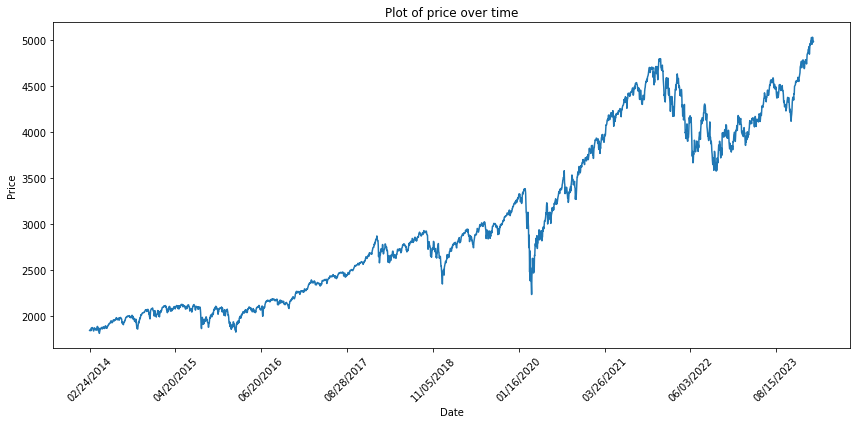

In [367]:
# plotting data

plot_chart(df, ["Close/Last"])

In [473]:
def normalize(input, scaler):
    output_norm = scaler.fit_transform(input.reshape(-1, 1))
    output_norm = output_norm.flatten()
    return output_norm

In [474]:
def denormalize(input_norm, scaler):
    output = scaler.inverse_transform(input_norm.reshape(-1, 1))
    output = output.flatten()
    return output

In [650]:
# normalizing

closing_prices = df["Close/Last"].values
apple_closing_prices = apple["Close"].values

minmax_scaler = MinMaxScaler(feature_range=(0,1))
closing_prices_norm = normalize(apple_closing_prices, minmax_scaler)

In [466]:
def prep_data(feature_vec_len, data):
    features = []
    labels = []
    data_len = len(data)

    for ind in range(data_len):
        feature_vec = []
        if ind < data_len - feature_vec_len:
            for ind2 in range(feature_vec_len):
                feature = data[ind + ind2]
                feature_vec.append(feature)

            label = data[ind + ind2 + 1]
            labels.append(label)
            features.append(feature_vec)

    features = np.array(features)
    labels = np.array(labels)

    return features, labels

In [651]:
# generating feature and label vectors

feature_vec_len = 6
features_norm, labels_norm = prep_data(feature_vec_len, closing_prices_norm)

In [468]:
# splitting into sets

X_train_norm, X_temp, y_train_norm, y_temp = train_test_split(features_norm, labels_norm, test_size=0.3, random_state=42, shuffle=False)
X_test_norm, X_val_norm, y_test_norm, y_val_norm = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

### 1. Linear Regression

In [339]:
#Technique 1: Linear Regression
#fit model to the last X (Hyperparam) days
#use model to predict price on day X+1
#eval

In [469]:
def fit_lin_reg(feature_vec_len, features_norm):
    linear_regressor = LinearRegression()
    days = np.arange(feature_vec_len).reshape(-1, 1)
    lin_reg_predictions = []

    for feature in features_norm:
        linear_regressor.fit(days, feature)
        pred = linear_regressor.predict(np.array(feature_vec_len + 1).reshape(-1, 1))
        lin_reg_predictions.append(pred[0])

    return np.array(lin_reg_predictions)

In [652]:
# fit models to every feature vector (split is not needed here)
lin_reg_predictions_norm = fit_lin_reg(feature_vec_len, features_norm)

In [509]:
def eval(predictions, labels):
    mae = mean_absolute_error(labels, predictions) #add feature_vec_len: to remove leading zeros
    mape = np.mean(np.abs((labels - predictions) / labels)) * 100

    return mae, mape

In [653]:
# eval

lin_reg_predictions = denormalize(lin_reg_predictions_norm, minmax_scaler)
labels = denormalize(labels_norm, minmax_scaler)

mae, mape = eval(lin_reg_predictions, labels)

print(f"MAE: {round(mae, 3)}")
print(f"MAPE: {round(mape, 3)}%")

MAE: 1.22
MAPE: 1.961%


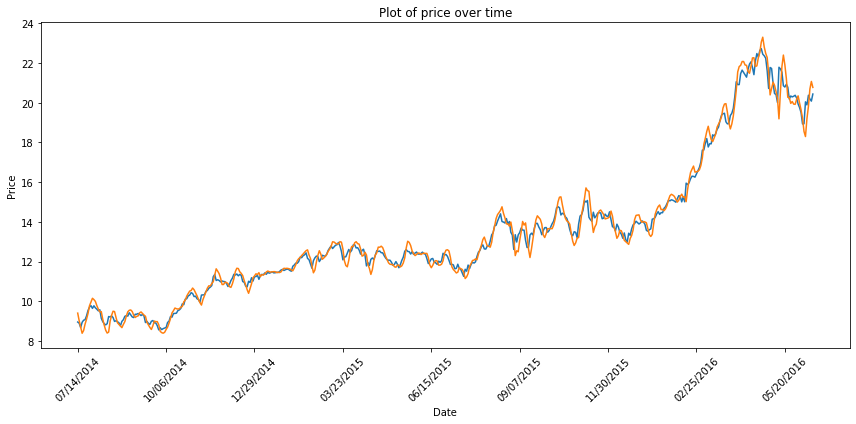

In [654]:
# plotting

start = 100
end = 600

plot_chart(df[start:end], [labels[start:end], lin_reg_predictions[start:end]], is_df=False)

In [655]:
# optimal feature vec len search

MAE_errors = []
MAPE_errors = []

for feature_vec_len in tqdm(range(1,30)):
    features_norm, labels_norm = prep_data(feature_vec_len, closing_prices_norm)
    lin_reg_predictions_norm = fit_lin_reg(feature_vec_len, features_norm)

    lin_reg_predictions = denormalize(lin_reg_predictions_norm, minmax_scaler)
    labels = denormalize(labels_norm, minmax_scaler)

    mae, mape = eval(lin_reg_predictions, labels)

    MAE_errors.append(mae)
    MAPE_errors.append(mape)

  0%|          | 0/29 [00:00<?, ?it/s]

100%|██████████| 29/29 [01:00<00:00,  2.10s/it]


Lowest MAE is 0.787, with feature vec len = 1 (just copies close from prev day)
Lowest MAPE is 1.257%, with feature vec len = 1 (just copies close from prev day)


Lowest MAE is 1.205, with non-trivial feature vec len = 7
Lowest MAPE is 1.959%, with non-trivial feature vec len = 7


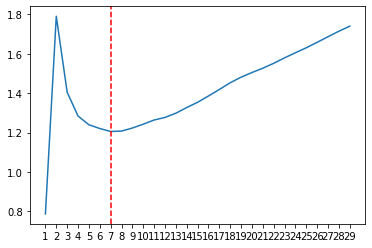

In [656]:
x_values = np.arange(1, len(MAE_errors) + 1)
plt.plot(x_values, MAE_errors)
plt.xticks(np.arange(1, len(MAE_errors) + 1, 1))

best_feat_vec_len_MAE, best_MAE = min(enumerate(MAE_errors), key=lambda x: x[1])
print(f"Lowest MAE is {round(best_MAE, 3)}, with feature vec len = {best_feat_vec_len_MAE + 1} (just copies close from prev day)")

best_feat_vec_len_MAPE, best_MAPE = min(enumerate(MAPE_errors), key=lambda x: x[1])
print(f"Lowest MAPE is {round(best_MAPE, 3)}%, with feature vec len = {best_feat_vec_len_MAPE + 1} (just copies close from prev day)")

MAE_errors_copy = MAE_errors.copy()
MAPE_errors_copy = MAPE_errors.copy()

print("\n")

MAE_errors_copy[best_feat_vec_len_MAE] = 1000000
MAPE_errors_copy[best_feat_vec_len_MAPE] = 1000000

sec_best_feat_vec_len_MAE, sec_best_MAE = min(enumerate(MAE_errors_copy), key=lambda x: x[1])
print(f"Lowest MAE is {round(sec_best_MAE, 3)}, with non-trivial feature vec len = {sec_best_feat_vec_len_MAE + 1}")

sec_best_feat_vec_len_MAPE, sec_best_MAPE = min(enumerate(MAPE_errors_copy), key=lambda x: x[1])
print(f"Lowest MAPE is {round(sec_best_MAPE, 3)}%, with non-trivial feature vec len = {sec_best_feat_vec_len_MAPE + 1}")

plt.axvline(x=sec_best_feat_vec_len_MAE + 1, color='red', linestyle='--', label='X=5')

In [649]:
# How much does the price change from day to day on average?
print(closing_prices)
percentage_changes = ((apple_closing_prices[1:] - apple_closing_prices[:-1]) / apple_closing_prices[:-1]) * 100

# Calculate the average percentage change
average_percentage_change = np.mean(percentage_changes)

print(f"Average change in closing price from day to day: {round(average_percentage_change, 3)}%") #modelle die schlechter sind als das sind komplett nutzlos

[1847.61 1845.12 1845.16 ... 5005.57 4975.51 4981.8 ]
Average change in closing price from day to day: 0.107%


Can I find a method that is better than just copying the value from the previous day?

### 2. Multilayer Perceptron

In [631]:
# generating feature and label vectors

feature_vec_len = 14
features_norm, labels_norm = prep_data(feature_vec_len, closing_prices_norm)

In [632]:
# splitting into sets

X_train_norm, X_temp, y_train_norm, y_temp = train_test_split(features_norm, labels_norm, test_size=0.3, random_state=42, shuffle=False)
X_test_norm, X_val_norm, y_test_norm, y_val_norm = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

shuffled_indices = np.random.permutation(len(X_train_norm))

X_train_norm = X_train_norm[shuffled_indices]
y_train_norm = y_train_norm[shuffled_indices]

In [633]:
def create_model(feature_vec_len):
    mlp_model = Sequential()
    mlp_model.add(Dense(units=128, input_dim=feature_vec_len, activation='relu'))
    mlp_model.add(Dense(units=64, activation='relu'))
    mlp_model.add(Dense(units=32, activation='relu'))
    mlp_model.add(Dense(units=16, activation='relu'))
    mlp_model.add(Dense(units=8, activation='relu'))
    mlp_model.add(Dense(units=4, activation='relu'))
    mlp_model.add(Dense(units=1, activation='linear'))

    mlp_model.compile(optimizer='adam', loss='mae')
    return mlp_model

In [634]:
# init model

mlp_model = create_model(feature_vec_len)

In [635]:
def train(mlp_model, X_train, y_train):
    history = mlp_model.fit(X_train, y_train, epochs=100, batch_size=1, validation_data=(X_val_norm, y_val_norm), verbose=1)
    return history

In [636]:
# training

history = train(mlp_model, X_train_norm, y_train_norm)

Epoch 1/100
1761/1761 [==============================] - 7s 3ms/step - loss: 0.0185 - val_loss: 0.0312
Epoch 2/100
1761/1761 [==============================] - 5s 3ms/step - loss: 0.0137 - val_loss: 0.0471
Epoch 3/100
1761/1761 [==============================] - 5s 3ms/step - loss: 0.0121 - val_loss: 0.0450
Epoch 4/100
1761/1761 [==============================] - 5s 3ms/step - loss: 0.0120 - val_loss: 0.0366
Epoch 5/100
1761/1761 [==============================] - 5s 3ms/step - loss: 0.0114 - val_loss: 0.0403
Epoch 6/100
1761/1761 [==============================] - 5s 3ms/step - loss: 0.0106 - val_loss: 0.0197
Epoch 7/100
1761/1761 [==============================] - 5s 3ms/step - loss: 0.0103 - val_loss: 0.0137
Epoch 8/100
1761/1761 [==============================] - 5s 3ms/step - loss: 0.0105 - val_loss: 0.0141
Epoch 9/100
1761/1761 [==============================] - 5s 3ms/step - loss: 0.0104 - val_loss: 0.0130
Epoch 10/100
1761/1761 [==============================] - 5s 3ms/step - l

In [603]:
def plot_loss(history, training=True):
    if training:
        training_loss = history.history["loss"]
        plt.plot(training_loss)
        plt.title('Training Loss Over Epochs')
    else:
        validation_loss = history.history["val_loss"]
        plt.plot(validation_loss)
        plt.title('Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Average Error Loss')
    plt.show()

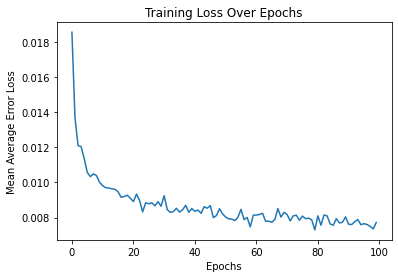

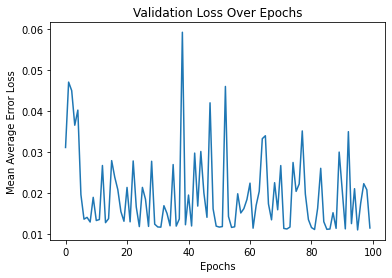

In [637]:
# plotting training loss

plot_loss(history)
plot_loss(history, training=False)

In [638]:
# eval

mlp_predictions_norm = mlp_model.predict(X_test_norm)

#todo denormalize
mlp_predictions = denormalize(mlp_predictions_norm, minmax_scaler)
y_test = denormalize(y_test_norm, minmax_scaler)

mae, mape = eval(mlp_predictions, y_test)

print(f"MAE: {round(mae, 3)}")
print(f"MAPE: {round(mape, 3)}%")

12/12 [==============================] - 0s 3ms/step
MAE: 40.656
MAPE: 0.958%


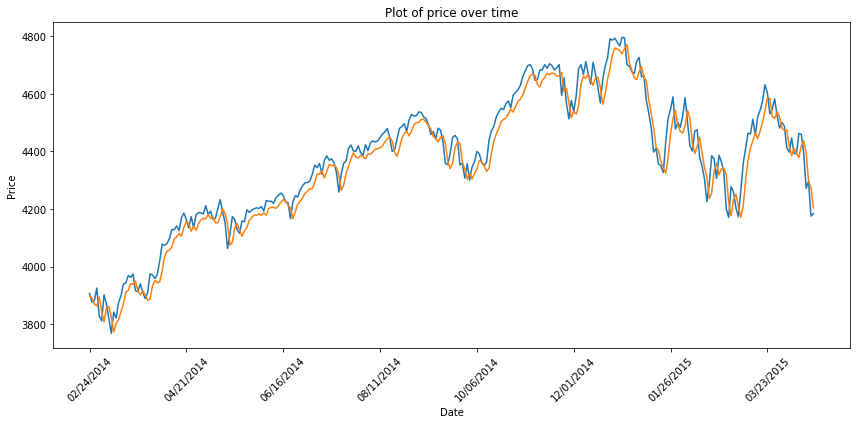

In [630]:
# plotting

start = 0
end = 300

plot_chart(df[start:end], [y_test[start:end], mlp_predictions[start:end]], is_df=False)

In [586]:
# optimal feature vec len search

MAE_errors = []
MAPE_errors = []

for feature_vec_len in tqdm(range(1,30)):
    features_norm, labels_norm = prep_data(feature_vec_len, closing_prices_norm)
    lin_reg_predictions_norm = fit_lin_reg(feature_vec_len, features_norm)

    X_train_norm, X_temp, y_train_norm, y_temp = train_test_split(features_norm, labels_norm, test_size=0.3, random_state=42, shuffle=False)
    X_test_norm, X_val_norm, y_test_norm, y_val_norm = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)
    shuffled_indices = np.random.permutation(len(X_train_norm))
    X_train_norm = X_train_norm[shuffled_indices]
    y_train_norm = y_train_norm[shuffled_indices]

    mlp_model = create_model(feature_vec_len)
    history = train(mlp_model, X_train_norm, y_train_norm)

    mlp_predictions_norm = mlp_model.predict(X_test_norm)

    mlp_predictions = denormalize(mlp_predictions_norm, minmax_scaler)
    y_test = denormalize(y_test_norm, minmax_scaler)

    mae, mape = eval(mlp_predictions, y_test)

    MAE_errors.append(mae)
    MAPE_errors.append(mape)

  0%|          | 0/29 [00:00<?, ?it/s]

12/12 [==============================] - 0s 2ms/step


  3%|▎         | 1/29 [01:15<35:03, 75.13s/it]

12/12 [==============================] - 0s 2ms/step


  7%|▋         | 2/29 [02:26<32:46, 72.84s/it]

12/12 [==============================] - 0s 2ms/step


 10%|█         | 3/29 [03:37<31:10, 71.93s/it]

12/12 [==============================] - 0s 2ms/step


 14%|█▍        | 4/29 [04:48<29:50, 71.61s/it]

12/12 [==============================] - 0s 2ms/step


 17%|█▋        | 5/29 [05:59<28:31, 71.31s/it]

12/12 [==============================] - 0s 2ms/step


 21%|██        | 6/29 [07:10<27:23, 71.45s/it]

12/12 [==============================] - 0s 3ms/step


 24%|██▍       | 7/29 [08:22<26:11, 71.43s/it]

12/12 [==============================] - 0s 2ms/step


 28%|██▊       | 8/29 [09:37<25:28, 72.77s/it]

12/12 [==============================] - 0s 2ms/step


 31%|███       | 9/29 [10:53<24:32, 73.63s/it]

12/12 [==============================] - 0s 3ms/step


 34%|███▍      | 10/29 [12:09<23:33, 74.41s/it]

12/12 [==============================] - 0s 2ms/step


 38%|███▊      | 11/29 [13:24<22:20, 74.45s/it]

12/12 [==============================] - 0s 2ms/step


 41%|████▏     | 12/29 [14:38<21:05, 74.43s/it]

12/12 [==============================] - 0s 2ms/step


 45%|████▍     | 13/29 [15:50<19:40, 73.78s/it]

12/12 [==============================] - 0s 2ms/step


 48%|████▊     | 14/29 [17:00<18:10, 72.68s/it]

12/12 [==============================] - 0s 2ms/step


 52%|█████▏    | 15/29 [18:09<16:40, 71.45s/it]

12/12 [==============================] - 0s 2ms/step


 55%|█████▌    | 16/29 [19:18<15:18, 70.66s/it]

12/12 [==============================] - 0s 2ms/step


 59%|█████▊    | 17/29 [20:27<14:03, 70.26s/it]

12/12 [==============================] - 0s 2ms/step


 62%|██████▏   | 18/29 [21:36<12:49, 69.93s/it]

12/12 [==============================] - 0s 2ms/step


 66%|██████▌   | 19/29 [22:49<11:49, 70.90s/it]

12/12 [==============================] - 0s 3ms/step


 69%|██████▉   | 20/29 [24:04<10:48, 72.02s/it]

12/12 [==============================] - 0s 2ms/step


 72%|███████▏  | 21/29 [25:21<09:46, 73.36s/it]

12/12 [==============================] - 0s 3ms/step


 76%|███████▌  | 22/29 [26:35<08:34, 73.54s/it]

12/12 [==============================] - 0s 2ms/step


 79%|███████▉  | 23/29 [27:49<07:23, 73.87s/it]

12/12 [==============================] - 0s 2ms/step


 83%|████████▎ | 24/29 [29:04<06:10, 74.19s/it]

12/12 [==============================] - 0s 2ms/step


 86%|████████▌ | 25/29 [30:20<04:58, 74.59s/it]

12/12 [==============================] - 0s 2ms/step


 90%|████████▉ | 26/29 [31:35<03:44, 74.90s/it]

12/12 [==============================] - 0s 2ms/step


 93%|█████████▎| 27/29 [32:50<02:29, 74.93s/it]

12/12 [==============================] - 0s 2ms/step


 97%|█████████▋| 28/29 [34:05<01:14, 74.82s/it]

12/12 [==============================] - 0s 2ms/step


100%|██████████| 29/29 [35:21<00:00, 73.14s/it]


Lowest MAE is 38.905, with feature vec len = 5
Lowest MAPE is 0.916%, with feature vec len = 5


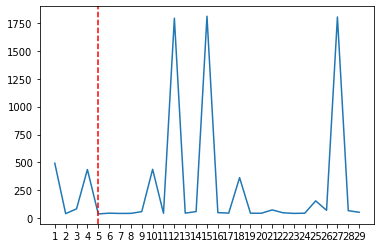

In [587]:
x_values = np.arange(1, len(MAE_errors) + 1)
plt.plot(x_values, MAE_errors)
plt.xticks(np.arange(1, len(MAE_errors) + 1, 1))

best_feat_vec_len_MAE, best_MAE = min(enumerate(MAE_errors), key=lambda x: x[1])
print(f"Lowest MAE is {round(best_MAE, 3)}, with feature vec len = {best_feat_vec_len_MAE + 1}")

best_feat_vec_len_MAPE, best_MAPE = min(enumerate(MAPE_errors), key=lambda x: x[1])
print(f"Lowest MAPE is {round(best_MAPE, 3)}%, with feature vec len = {best_feat_vec_len_MAPE + 1}")

plt.axvline(x=best_feat_vec_len_MAE + 1, color='red', linestyle='--', label='X=5')

### 3. RNN

In [241]:
from keras.layers import Dense, SimpleRNN

In [245]:
# prep data

feature_vec_len = 15

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, label_scaler = prep_data(feat_vec_len)

In [260]:
# model

rnn = Sequential()
rnn.add(SimpleRNN(units=50, activation='relu', input_shape=(X_train_scaled.shape[1], 1)))
rnn.add(Dense(units=1))
rnn.compile(optimizer='adam', loss=['mean_squared_error', 'mae'])

In [261]:
# train

rnn_history = rnn.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=64, validation_data=(X_test_scaled, y_test_scaled))

Epoch 1/50
24/24 [==============================] - 2s 21ms/step - loss: 0.0449 - val_loss: 0.0083
Epoch 2/50
24/24 [==============================] - 0s 6ms/step - loss: 0.0033 - val_loss: 0.0041
Epoch 3/50
24/24 [==============================] - 0s 6ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 4/50
24/24 [==============================] - 0s 6ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 5/50
24/24 [==============================] - 0s 7ms/step - loss: 0.0019 - val_loss: 0.0029
Epoch 6/50
24/24 [==============================] - 0s 12ms/step - loss: 0.0019 - val_loss: 0.0029
Epoch 7/50
24/24 [==============================] - 0s 8ms/step - loss: 0.0019 - val_loss: 0.0037
Epoch 8/50
24/24 [==============================] - 0s 7ms/step - loss: 0.0018 - val_loss: 0.0029
Epoch 9/50
24/24 [==============================] - 0s 7ms/step - loss: 0.0018 - val_loss: 0.0030
Epoch 10/50
24/24 [==============================] - 0s 7ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 11/50
24/24

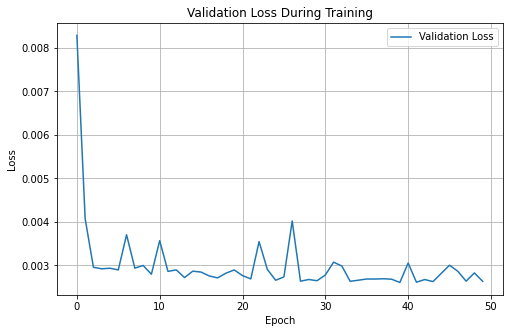

In [262]:
# plot val loss

val_loss = rnn_history.history['val_loss']

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss During Training')
plt.legend()
plt.grid(True)
plt.show()

In [263]:
# eval
# def eval(model, label_scaler, X_test_scaled, y_test_scaled):

mse, y_test, y_pred = eval(rnn, label_scaler, X_test_scaled, y_test_scaled)

print(mse)

12/12 [==============================] - 0s 3ms/step
1501.2307696796718


In [255]:
# def hyperparam_search(m, feat_vec_len, model):

errors = hyperparam_search(25, rnn)

  0%|          | 0/24 [00:00<?, ?it/s]

13/13 [==============================] - 0s 2ms/step


  4%|▍         | 1/24 [00:27<10:32, 27.49s/it]

13/13 [==============================] - 0s 2ms/step


  8%|▊         | 2/24 [00:54<10:04, 27.47s/it]

13/13 [==============================] - 0s 2ms/step


 12%|█▎        | 3/24 [01:23<09:50, 28.11s/it]

13/13 [==============================] - 0s 2ms/step


 17%|█▋        | 4/24 [01:53<09:36, 28.82s/it]

13/13 [==============================] - 0s 2ms/step


 21%|██        | 5/24 [02:25<09:25, 29.74s/it]

13/13 [==============================] - 0s 2ms/step


 25%|██▌       | 6/24 [03:00<09:30, 31.71s/it]

13/13 [==============================] - 0s 2ms/step


 29%|██▉       | 7/24 [03:39<09:40, 34.16s/it]

13/13 [==============================] - 0s 2ms/step


 33%|███▎      | 8/24 [04:14<09:09, 34.35s/it]

13/13 [==============================] - 0s 2ms/step


 38%|███▊      | 9/24 [04:49<08:36, 34.46s/it]

13/13 [==============================] - 0s 2ms/step


 42%|████▏     | 10/24 [05:25<08:09, 34.95s/it]

13/13 [==============================] - 0s 2ms/step


 46%|████▌     | 11/24 [05:59<07:30, 34.64s/it]

13/13 [==============================] - 0s 2ms/step


 50%|█████     | 12/24 [06:33<06:55, 34.65s/it]

13/13 [==============================] - 0s 2ms/step


 54%|█████▍    | 13/24 [07:11<06:30, 35.54s/it]

13/13 [==============================] - 0s 2ms/step


 58%|█████▊    | 14/24 [07:48<06:00, 36.04s/it]

13/13 [==============================] - 0s 2ms/step


 62%|██████▎   | 15/24 [08:26<05:28, 36.45s/it]

13/13 [==============================] - 0s 2ms/step


 67%|██████▋   | 16/24 [09:04<04:55, 36.93s/it]

13/13 [==============================] - 0s 2ms/step


 71%|███████   | 17/24 [09:43<04:23, 37.67s/it]

13/13 [==============================] - 0s 2ms/step


 75%|███████▌  | 18/24 [10:22<03:48, 38.15s/it]

13/13 [==============================] - 0s 2ms/step


 79%|███████▉  | 19/24 [11:02<03:13, 38.74s/it]

13/13 [==============================] - 0s 2ms/step


 83%|████████▎ | 20/24 [11:44<02:38, 39.62s/it]

13/13 [==============================] - 0s 2ms/step


 88%|████████▊ | 21/24 [12:27<02:01, 40.64s/it]

13/13 [==============================] - 0s 2ms/step


 92%|█████████▏| 22/24 [13:08<01:21, 40.81s/it]

13/13 [==============================] - 0s 1ms/step


 96%|█████████▌| 23/24 [13:51<00:41, 41.47s/it]

12/12 [==============================] - 0s 2ms/step


100%|██████████| 24/24 [14:34<00:00, 36.42s/it]


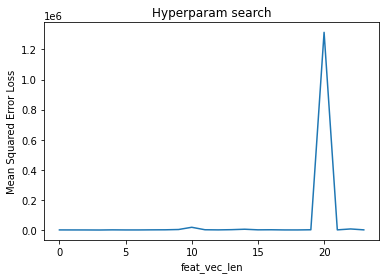

Lowest MSE is 1563.2681824462866, with feature vec length=4


In [257]:
aux1(errors)

In [259]:
rnn.summary()

Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 50)                2600      
                                                                 
 dense_170 (Dense)           (None, 1)                 51        
                                                                 
Total params: 2651 (10.36 KB)
Trainable params: 2651 (10.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 4. Transformer

### 5. Reinforcement Learning


### 6. Brain